# The Electron Collection
```{warning}
Not all examples on this page have been updated to r22 and ServiceX 3. Examples that have not been updated will be marked using a similar warning. These examples will be updated soon.
```
The electron collection is a lot like the jet collection other than there are working points (loose, medium, tight) that are defined by the Egamma working group.

Accessing the collection is similar, at first blush, to the jet collection.

In [1]:
from config import deliver_files
from config import sx_f
from func_adl_servicex_xaodr22 import FuncADLQueryPHYSLITE, cpp_float, cpp_vfloat

import matplotlib.pyplot as plt
import numpy as np
import uproot
import awkward as ak

The default electron we fetch is the so-called `MediumLHElectron` electron with `NonIso` isolation.

In [2]:
query = FuncADLQueryPHYSLITE()
electrons_per_event = query.Select(lambda e: e.Electrons())
electron_info_per_event = electrons_per_event.Select(
    lambda electrons: {
        'pt': electrons.Select(lambda j: j.pt() / 1000),
    }
)

files = deliver_files(electron_info_per_event,sx_f)

Output()

In [3]:
pt_data = []
for file_path in files:
    file = uproot.open(file_path)
    array = file['atlas_xaod_tree;1']['pt'].arrays(library="ak").pt
    pt_data.extend(ak.flatten(array))

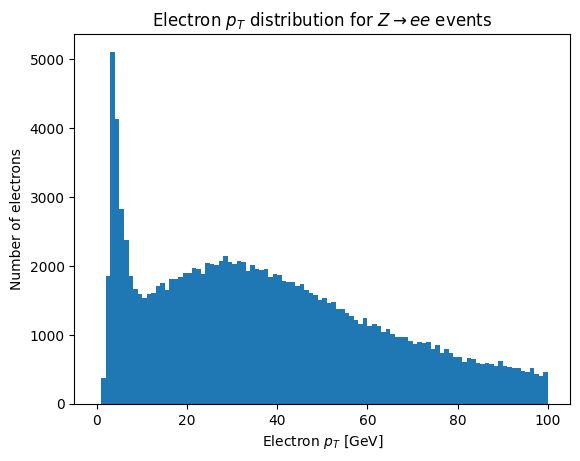

In [4]:
plt.hist(pt_data, bins=100, range=(0, 100))
plt.xlabel('Electron $p_T$ [GeV]')
plt.ylabel('Number of electrons')
_ = plt.title('Electron $p_T$ distribution for $Z\\rightarrow ee$ events')

(sec-ele-wp)=
## Electron Types


```{warning}
This example has not been updated to r22 and ServiceX 3 yet.
```

Electrons come in several different flavors. We can look at the different $\eta$ distributions for the electrons. Isolation is another axis we can alter, not shown here, by changing the `electron_isolation` argument to `Electrons`.

In the [calibration](ch-calibration) chapter we pointed out we can't run multiple queries with different object setups due to limitations in the xAOD AnalysisBase when looking at calibrated objects. So we'll have to do this in three queries instead. Also, we'll have them run in parallel to improve efficiency a bit.

In [4]:
ele_working_points = ['LooseLHElectron', 'MediumLHElectron','TightLHElectron']
electrons_async = [
    (calib_tools.query_update(ds, electron_working_point=wp)
        .SelectMany(lambda e: [ele.eta() for ele in e.Electrons()])
        .AsAwkwardArray('eta')
        .value_async())
    for wp in ele_working_points
]
electrons_wp = await asyncio.gather(*electrons_async)

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

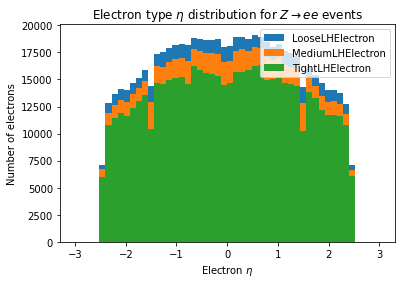

In [5]:
for idx, wp in enumerate(ele_working_points):
    plt.hist(electrons_wp[idx].eta, bins=50, range=(-3, 3), label=wp)
plt.xlabel('Electron $\\eta$')
plt.ylabel('Number of electrons')
plt.title('Electron type $\\eta$ distribution for $Z\\rightarrow ee$ events')
_ = plt.legend()

## Calibration


```{warning}
This example has not been updated to r22 and ServiceX 3 yet.
```

By default the muons we pulled are `MediumLHElectron` quality and calibrated. We can grab the uncalibrated electrons easily enough:

To grab the raw jets (without calibration) we just set the `calibrated` parameter to `False` (there is very little reason one will do this normally):

In [6]:
raw_electrons = ( ds
                 .Select(lambda e: e.Electrons(uncalibrated_collection="Electrons"))
                 .Select(lambda eles: {
                      'pt': [e.pt() / 1000.0 for e in eles],
                      'eta': [e.eta() for e in eles],
                      'phi': [e.phi() for e in eles],
                      })
                 .AsAwkwardArray()
                 .value())

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

The number of raw jets and the number of calibrated jets are quite different from the number of raw jets, so we'll need to match them in $\eta$ and $\phi$:

In [7]:
raw_electrons_matched = match_objects(electrons, raw_electrons)

And we can compared the matched electrons:

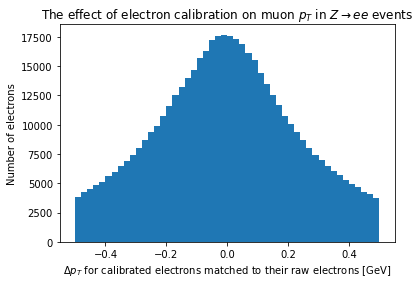

In [8]:
plt.hist(ak.flatten(electrons.pt-raw_electrons_matched.pt), bins=50, range=(-0.5, 0.5))
plt.xlabel(r'$\Delta p_T$ for calibrated electrons matched to their raw electrons [GeV]')
plt.ylabel('Number of electrons')
_ = plt.title('The effect of electron calibration on muon $p_T$ in $Z\\rightarrow ee$ events')

If we instead want a particular systematic error, we need only name that error to get it back. Knowing what the names of the systematic errors, however, is not something that can be programmatically determined ahead of time. See the further information section at the end of this chapter to links to the ATLAS electron calibration info twiki. Though I've noticed it is not necessarily up to date with names.

In [9]:
sys_electrons = (calib_tools.query_sys_error(ds, 'EG_RESOLUTION_ALL__1up')
                 .Select(lambda e: e.Electrons())
                 .Select(lambda eles: {
                      'pt': [e.pt() / 1000.0 for e in eles],
                      'eta': [e.eta() for e in eles],
                      'phi': [e.phi() for e in eles],
                      })
                 .AsAwkwardArray()
                 .value())

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

In [10]:
sys_electrons_match = match_objects(electrons, sys_electrons)

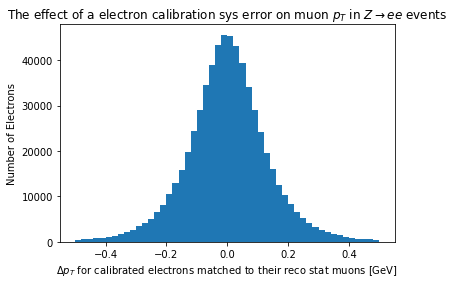

In [11]:
plt.hist(ak.flatten(electrons.pt-sys_electrons_match.pt), bins=50, range=(-0.5, 0.5))
plt.xlabel('$\Delta p_T$ for calibrated electrons matched to their reco stat muons [GeV]')
plt.ylabel('Number of Electrons')
_ = plt.title('The effect of a electron calibration sys error on muon $p_T$ in $Z\\rightarrow ee$ events')

## The Data Model

The `Electron_v1` class at the time this documentation was built:

In [1]:
from func_adl_servicex_xaodr22.xAOD.electron_v1 import Electron_v1
help(Electron_v1)

Help on class Electron_v1 in module func_adl_servicex_xaodr22.xAOD.electron_v1:

class Electron_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  OQ(self) -> 'int'
 |      A method
 |  
 |  ambiguousObject(self) -> 'func_adl_servicex_xaodr22.xAOD.egamma_v1.Egamma_v1'
 |      A method
 |  
 |  caloCluster(self, index: 'int') -> 'func_adl_servicex_xaodr22.xAOD.calocluster_v1.CaloCluster_v1'
 |      A method
 |  
 |  caloClusterLink(self, index: 'int') -> 'func_adl_servicex_xaodr22.elementlink_datavector_xaod_calocluster_v1__.ElementLink_DataVector_xAOD_CaloCluster_v1__'
 |      A method
 |  
 |  caloClusterLinks(self) -> 'func_adl_servicex_xaodr22.vector_elementlink_datavector_xaod_calocluster_v1___.vector_ElementLink_DataVector_xAOD_CaloCluster_v1___'
 |      A method
 |  
 |  charge(self) -> 'float'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method

## Further Information

* The [`xAOD::Electron_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODEgamma/xAODEgamma/versions/Electron_v1.h) with all the inline documentation.
* The [Electron Recommendation Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/LatestRecommendationsElectronIDRun2) on the ATLAS TWiki
* The [Electron Working Points Pages for R21](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/EGammaIdentificationRun2) on the ATLAS Twiki